# **SDGym - Synthetic Data Gym**

**Synthetic Data Gym** (SDGym) is a framework to benchmark the performance of synthetic data generators based on SDV and SDMetrics:

*   Learn a tabular model to synthesize rows in a table
*   Learn a relational data model to synthesize multiple, related tables
*   Learn a time-series model to synthesize new events

GitHub Link: https://github.com/sdv-dev/SDGym

A **Synthetic Data Generator** is a Python function (or method) that takes as input some data, which we call the real data, learns a model from it, and outputs new synthetic data that has the same structure and similar mathematical properties as the real one.

In [31]:
import os
import sys
import platform
OS = platform.system()   # Operating System                                                             # returns 'Windows', 'Linux', etc

#**Platform Settings**

In [32]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

Colab Active:  True


# **Libraries Installation Section**

Installation of all required libraries: SDGym, gdown, pandas

In [33]:
os.system('pip install --upgrade --no-cache-dir gdown')
os.system('pip install sdgym')
os.system('pip install pandas')
os.system('pip install matplotlib==3.1.3')

0

# **All Imports**

In [34]:
import timeit
import numpy as np
import pandas as pd
from sdv.demo import load_tabular_demo
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN
from sdv.evaluation import evaluate
from sdv.metrics.tabular import CSTest, KSTest                                      # Statistical Metrics
from sdv.metrics.tabular import BNLikelihood, BNLogLikelihood, GMLogLikelihood      # Likelihood Metrics¶
from sdv.metrics.tabular import LogisticDetection, SVCDetection                     # Detection Metrics
from sdv.metrics.tabular import MulticlassDecisionTreeClassifier                    # Machine Learning Efficacy Metrics¶
from sdv.metrics.tabular import NumericalLR                                         # Privacy Metrics

# **All Globals**

In [35]:
benchmark = False
gaussian_copula_synth_model = False 
ctgan_synth_model = False
copula_gan_synth_model = True
dataset = 'telephony'   # satgpa, acs, telephony
model_names = []
limit_to_generate = 1000  # or None
training = False
save_score = False
test_model_name = "telephony_copulagan.pkl"

#**All Hyper-parameters**

In [36]:
epochs = 2

# **All Settings**

In [37]:
start_global_time = timeit.default_timer()
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 
if ctgan_synth_model == True and copula_gan_synth_model == True: # Only one Gan 
  ctgan_synth_model = False

#**Mounting Google Drive via Code**

In [38]:
if colab_active is True: 
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive')
  model_path = "/content/drive/MyDrive/DL_Models/"
  if os.path.isdir(model_path) is False: 
    os.makedirs(model_path) 
else: 
  model_path = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **All Functions Definitions**

In [39]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download - ACS, SatGPA, Telephony**

In [40]:
if benchmark == True: 
  data = load_tabular_demo('student_placements')
  n_to_generate = data.shape[0]
else: 
  if dataset is 'satgpa':
    out = data_download("./satgpa.csv", "1NNVF1LhBDkW_KKp5_QW8cAiQDFatzWMy", OS, False)
    data = pd.read_csv('./satgpa.csv')
    data = data.drop(['sat_sum'], axis=1)
    data.to_csv('satgpa_no_sum.csv', sep=',')
    n_to_generate = data.shape[0]
  elif dataset is 'acs':
    out = data_download("./acs_dataset.zip", "1mKZfDieGBJP-cS-R7_i3zVKVawXThfUc", OS)
    if limit_to_generate is not None: 
      data = pd.read_csv('./acs_dataset.csv', nrows = limit_to_generate)
      n_to_generate = limit_to_generate
    else: 
      data = pd.read_csv('./acs_dataset.csv')
      n_to_generate = data.shape[0]
  elif dataset is 'telephony':
    out = data_download("./syntetic_telephony.zip", "1knlC9DQ-iQhxwpmd9qzFWSS0OcgI9-LA", OS)
    xl_file = pd.ExcelFile('./syntetic_telephony.xlsx')
    dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
    data = dfs['Sheet1']
    n_to_generate = data.shape[0]

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CHIAVE_NUM_CHIAMANTE  10000 non-null  float64
 1   DATA_CHIAMATA         10000 non-null  int64  
 2   ORA_MIN_CHIAMATA      10000 non-null  int64  
 3   COD_CELLA_CHIAMATA    10000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


# **Exploratory Analysis**

In [42]:
data.COD_CELLA_CHIAMATA=data.COD_CELLA_CHIAMATA.astype("int64").astype("str")
data["COD_CELLA_CHIAMATA"]="F"+data.COD_CELLA_CHIAMATA

data.DATA_CHIAMATA=pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d')
data.CHIAVE_NUM_CHIAMANTE=data.CHIAVE_NUM_CHIAMANTE.astype("int64").astype("str")
data["CHIAVE_NUM_CHIAMANTE"]="F"+data.CHIAVE_NUM_CHIAMANTE

data.ORA_MIN_CHIAMATA=data.ORA_MIN_CHIAMATA.astype("str").str.pad(width=6, side='left', fillchar='0')
data.ORA_MIN_CHIAMATA =pd.to_datetime(data.ORA_MIN_CHIAMATA , format='%H%M%S')


In [43]:
explore_data(data)


Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0   F14615194667453690    2017-01-22 1900-01-01 15:49:53                 F0
1   F14615194667453690    2017-01-29 1900-01-01 12:40:34                 F1
2   F14615194667453690    2017-01-29 1900-01-01 12:41:19                 F1
3   F14615194667453690    2017-01-22 1900-01-01 15:51:02                 F1
4   F14615194667453690    2017-01-22 1900-01-01 15:51:38                 F1

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995   F14615368752090240    2017-01-12 1900-01-01 12:09:10               F272
9996   F14615368752090240    2017-02-12 1900-01-01 18:26:01               F272
9997    F1508338528891430    2017-01-04 1900-01-01 09:26:27               F272
9998   F14615368752090240    2017-02-10 1900-01-01 15:11:58               F272
9999   F14615337422429130    2017-01-30 1900-01-01 09:09:03               F272

Shape of Data:  (10000, 4)

Informa

# **Synthetic Data Generation via Gaussian Copula Method**

In mathematical terms, a copula is a distribution over the unit cube [0,1]d which is constructed from a multivariate normal distribution over Rd by using the probability integral transform. Intuitively, a copula is a mathematical function that allows us to describe the joint distribution of multiple random variables by analyzing the dependencies between their marginal distributions.

In [44]:
if gaussian_copula_synth_model == True and training is True:
  model = GaussianCopula()
  model.fit(data)
  model_names.append(model_path+dataset+'_gaussian_copula.pkl')
  model.save(model_names[-1])

# **Synthetic Data Generation via Conditional GAN**

Modeling the probability distribution of rows in tabular data and generating realistic synthetic data is a non-trivial task. Tabular data usually contains a mix of discrete and continuous columns. Continuous columns may have multiple modes whereas discrete columns are sometimes imbalanced making the modeling difficult. Existing statistical and deep neural network models fail to properly model this type of data. We design TGAN, which uses a conditional generative adversarial network to address these challenges. To aid in a fair and thorough comparison, we design a benchmark with 7 simulated and 8 real datasets and several Bayesian network baselines. TGAN outperforms Bayesian methods on most of the real datasets whereas other deep learning methods could not.

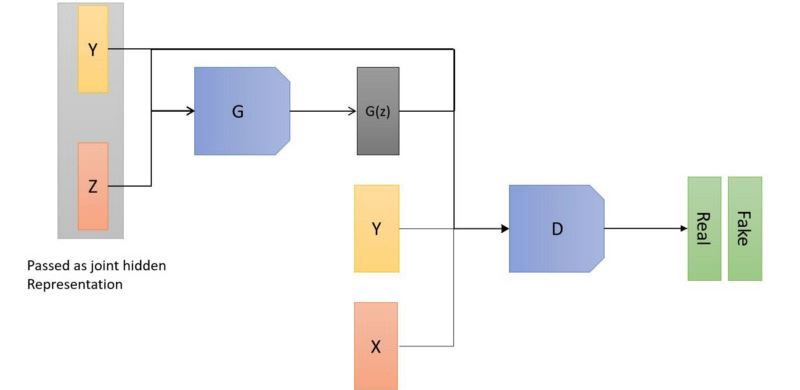

In [45]:
if ctgan_synth_model == True and training is True:
  model = CTGAN(
    epochs=epochs,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(model_path+dataset+'_ctgan.pkl')
  model.save(model_names[-1])

# **Synthetic Data Generation via Copula GAN**

The CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.




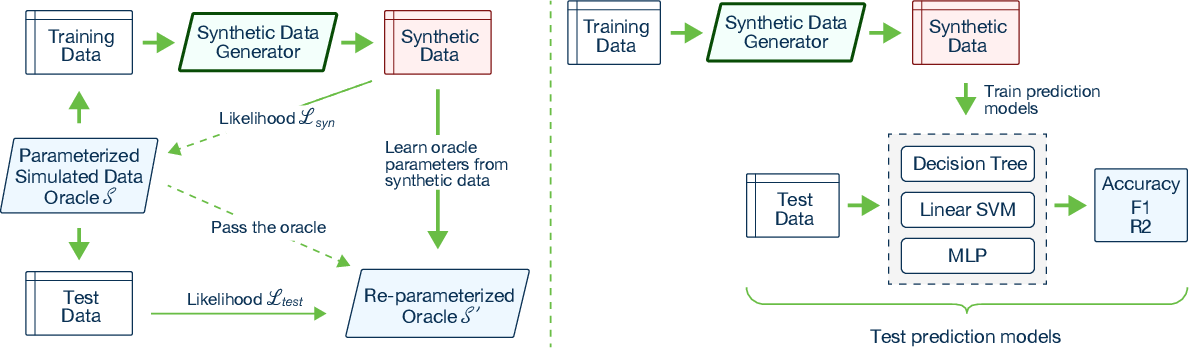

In [46]:
if copula_gan_synth_model == True and training is True:
  model = CopulaGAN(
    epochs=epochs,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(model_path+dataset+'_copulagan.pkl')
  model.save(model_names[-1])

# **Model Loading and Preparation**

In [47]:
if training is True: 
  model_file = []
  model_to_load = []
  if gaussian_copula_synth_model == True:
    model_file.append(model_names[0])
    model_to_load.append(("GaussianCopula", GaussianCopula))
  if ctgan_synth_model == True:
    model_file.append(model_names[-1])
    model_to_load.append(("CTGAN", CTGAN))
  elif copula_gan_synth_model == True:
    model_file.append(model_names[-1])
    model_to_load.append(("COPULAGAN", CopulaGAN))

  loaded_model = []
  for mf,ml in zip(model_file, model_to_load): 
    loaded_model.append((ml[0], ml[1].load(mf)))

# **Synthetic Data Generation**

In [48]:
if training is True:
  synthetic_data = []
  for lm in loaded_model: 
    synthetic_data.append((lm[0], lm[1].sample(n_to_generate)))

# **Synthetic Data Exploratory Analysis**

#**Aggregated Score**

The aggregated score is a value between 0 and 1, and it is an average of all the following metrics

In [49]:
if training is True: 
  scored_and_synth_data = []
  for sd in synthetic_data:
    try:
      print("\nMethod: ",sd[0])
      explore_data(sd[1])
      if save_score is True: 
        score = evaluate(sd[1], data)
        print("\n\nScore: ", score)
      else: 
        score = -1
      scored_and_synth_data.append((sd[0], sd[1], score))  
    except:
      print("Error")


In [50]:
total_time = timeit.default_timer() - start_global_time

In [51]:
if training is True: 
  for sas in scored_and_synth_data:
    sas[1].to_csv(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.csv', sep=',')

In [52]:
if training is True: 
  for sas in scored_and_synth_data:
    sas[1].to_excel(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.xlsx')

In [53]:
print("Global Exectution Time: ", total_time)

Global Exectution Time:  3.3368085920000112


#**Model Evaluation**

In [60]:
print(model_path+test_model_name)

/content/drive/MyDrive/DL_Models/telephony_copulagan.pkl


Loading the trained model...

In [59]:
if training is False: 
  if copula_gan_synth_model == True:
    model = CopulaGAN(    
      epochs=epochs,
      batch_size=100,
      generator_dim=(256, 256, 256),
      discriminator_dim=(256, 256, 256)
    )

  model.load(model_path+test_model_name)
  synthetic_data = model.sample(n_to_generate)


AttributeError: ignored

In [57]:
model

#**Statistical Metrics**

The metrics of this family compare the tables by running different types of statistical tests on them. In the most simple scenario, these metrics compare individual columns from the real table with the corresponding column from the synthetic table, and at the end report the average outcome from the test.

**sdv.metrics.tabular.KSTest:** This metric uses the two-sample Kolmogorov–Smirnov test to compare the distributions of continuous columns using the empirical CDF. The output for each column is 1 minus the KS Test D statistic, which indicates the maximum distance between the expected CDF and the observed CDF values.

**sdv.metrics.tabular.CSTest:** This metric uses the Chi-Squared test to compare the distributions of two discrete columns. The output for each column is the CSTest p-value, which indicates the probability of the two columns having been sampled from the same distribution.


In [ ]:
if OS!="Linux" or colab_active is True:
  print(CSTest.compute(data, synthetic_data))
  print(KSTest.compute(data, synthetic_data))

#**Likelihood Metrics**

The metrics of this family compare the tables by fitting the real data to a probabilistic model and afterwards compute the likelihood of the synthetic data belonging to the learned distribution.



**sdv.metrics.tabular.BNLikelihood:** This metric fits a BayesianNetwork to the real data and then evaluates the average likelihood of the rows from the synthetic data on it.

**sdv.metrics.tabular.BNLogLikelihood:** This metric fits a BayesianNetwork to the real data and then evaluates the average log likelihood of the rows from the synthetic data on it.

**sdv.metrics.tabular.GMLogLikelihood:** This metric fits multiple GaussianMixture models to the real data and then evaluates the average log likelihood of the synthetic data on them.


In [ ]:
if OS!="Linux" or colab_active is True:
  print(BNLikelihood.compute(data.fillna(0), synthetic_data.fillna(0)))
  print(BNLogLikelihood.compute(data.fillna(0), synthetic_data.fillna(0)))

#**Detection Metrics**

The metrics of this family evaluate how hard it is to distinguish the synthetic data from the real data by using a Machine Learning model. To do this, the metrics will shuffle the real data and synthetic data together with flags indicating whether the data is real or synthetic, and then cross validate a Machine Learning model that tries to predict this flag. The output of the metrics will be the 1 minus the average ROC AUC score across all the cross validation splits.

Such metrics are:

**sdv.metrics.tabular.LogisticDetection**: Detection metric based on a LogisticRegression classifier from scikit-learn.

**sdv.metrics.tabular.SVCDetection:** Detection metric based on a SVC classifier from scikit-learn.

#**Privacy Metrics**

This family of metrics measures the privacy of a synthetic dataset by positing the question: given the synthetic data, can an attacker predict sensitive attributes in the real dataset? These models accomplish this by fitting an adversarial attacker model on the synthetic data to predict sensitive attributes from “key” attributes and then evaluating its accuracy on the real data.

The metrics on this family are organized according to the data type they take as input:

    Categorical metrics:

        sdv.metrics.tabular.CategoricalCAP

        sdv.metrics.tabular.CategoricalZeroCAP

        sdv.metrics.tabular.CategoricalGeneralizedCAP

        sdv.metrics.tabular.CategoricalKNN

        sdv.metrics.tabular.CategoricalNB

        sdv.metrics.tabular.CategoricalRF

        sdv.metrics.tabular.CategoricalEnsemble

    Numerical metrics:

        sdv.metrics.tabular.NumericalMLP

        sdv.metrics.tabular.NumericalLR

        sdv.metrics.tabular.NumericalSVR

        sdv.metrics.tabular.NumericalRadiusNearestNeighbor


In addition to the real and synthetic data, these metrics also require two additional inputs, sensitive_fields which is a list of columns considered private and key_fields which are the columns that will be used to try to predict the sensitive ones.

Using the demo data set, one possible example is to use:

    salary as a sensitive column, which is the column we are measuring ahow private it is

    second_perc, mba_perc and degree_perc as the key columns, which will be used by the adversarial attacker to predict the sensitive column

Notice that as all the involved columns are numerical, we need to apply a numerical privacy metric. Conversely, if all of the columns are categorical, we need to use a categorical privacy metric. Currently, the privacy metrics do not support mixed data types.

**Note:**These metrics do not accept missing data, so we will replace all the missing values with a 0 before executing them.

In [ ]:
if OS!="Linux" or colab_active is True:
  NumericalLR.compute(
          data.fillna(0), 
          synthetic_data.fillna(0),
              key_fields=['second_perc', 'mba_perc', 'degree_perc'],
              sensitive_fields=['salary']
          )

#**Output Visual Analysis**

In [ ]:
if OS!="Linux" or colab_active is True:
  outputData=pd.read_excel("/content/telephony_synth_data_generated_by_method_copulagantotal_time_3309.26_score_0.429.xlsx")

  pd.DataFrame(data.CHIAVE_NUM_CHIAMANTE.value_counts()).hist(bins=20)
  plt.show()

  pd.DataFrame(outputData.CHIAVE_NUM_CHIAMANTE.value_counts()).hist(bins=20)
  plt.show()

  A=set(data.CHIAVE_NUM_CHIAMANTE.astype("str"))
  B=set(outputData.CHIAVE_NUM_CHIAMANTE.astype("str"))
  print(B.difference(A))

  print(data.info())


  pd.DataFrame(data.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
  plt.show()

  pd.DataFrame(outputData.COD_CELLA_CHIAMATA.value_counts()).hist(bins=20)
  plt.show()

  outputData.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
  plt.show()
  data.plot.scatter("COD_CELLA_CHIAMATA","DATA_CHIAMATA")
  plt.show()

  data.ORA_MIN_CHIAMATA.hist()
  plt.show()
  outputData.info()
  outputData

  pd.to_datetime(outputData.DATA_CHIAMATA, format='%Y%m%d').hist()

  pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d').hist()

  data.ORA_MIN_CHIAMATA.hist()
  plt.show()
  outputData.info()
  outputData

  data.ORA_MIN_CHIAMATA.hist()

  inputData=sas[1]
  pd.DataFrame(inputData).COD_CELLA_CHIAMATA.plot()

  data.COD_CELLA_CHIAMATA.value_counts()